## Sentiment Analysis of Tweets

In [247]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import os, spacy, zipfile
from sklearn.model_selection import train_test_split
from sklearn import metrics
from urllib.request import urlretrieve, urlopen

import torch
import torch.autograd as grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [74]:
# Download twitter glove

if os.path.exists('glove'):
        print('The file is already downloaded')
else:
    glove_link = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
    glove_name = "glove.twitter.27B.zip"
    glove_name, _ = urlretrieve(glove_link,glove_name)
    # unziping
    with zipfile.ZipFile(glove_name,'r') as f:
        f.extractall('glove')

The file is already downloaded


In [76]:
#loading the glove model
# every line of a glove file is "word" following by its vector representation

def load_glov_model(glovefile):
    print('Loading Glove words embeddings ...')
    f = open(glovefile,'r',encoding="utf8")
    model = {}
    for line in f:
        line_ = line.split()
        word = line_[0]
        embedding = [float(val) for val in line_[1:]]
        model[word] = embedding
    f.close()
    print('Done !', len(model), 'words loaded.')
    return model
        
model = load_glov_model('glove/glove.twitter.27B.200d.txt')

Loading Glove words embeddings ...
Done ! 1193514 words loaded.


In [2]:
# Download the training data from github
file="https://raw.githubusercontent.com/crwong/cs224u-project/master/data/sentiment/training.1600000.processed.noemoticon.csv"
file_name = "Tweets.csv"

if os.path.exists(file_name):
    print('The file',file_name,'is already downloaded')
else:
    filename, _ = urlretrieve(file,filename=file_name)

The file Tweets.csv is laready downloaded


In [4]:
! python -m spacy.en.download

Downloading...

archive.gz checksum/md5 OK


Model successfully installed.


In [5]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en')

In [236]:
#load the dataset
data=pd.read_csv(file_name, encoding= "latin-1",header=None)

y = data[0]
X = data[5]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)
y_train = pd.get_dummies(y_train)[0]
y_test  = pd.get_dummies(y_test)[0]

In [237]:
# function to remove stopwords
def stopwords(sentence):
    new = []
    sen = nlp(sentence)
    for w in sen:
        if (w.is_stop == False) & (w.pos_ != "PUNCT"):
            new.append(w.string.strip())
    #c = " ".join(str(x) for x in new)
    c = " ".join(new)
    return c

# function to lematise the wteets
def lemmatise(sentence):
    sen = nlp(sentence)
    str_ = ""
    for w in sen:
        str_ += " "+w.lemma_
    return nlp(str_)

#vectorising the sentences
def sent_vect(sent, model):
    sent_vec = np.zeros(200)
    numw = 0
    for w in sent.split():
        try:
            sent_vec = np.add(sent_vec, model[str(w)])
            numw += 1
        except:
            pass
    return sent_vec

In [238]:
#Vectorising the datasets
X_train_clean = []
for i in range(X_train.shape[0]):
    doc= str(lemmatise(stopwords(X_train[i].lower())))
    X_train_clean.append(sent_vect(doc,model))

X_train_clean = np.array(X_train_clean)

X_test_clean = []
for i in range(X_test.shape[0]):
    doc= str(lemmatise(stopwords(X_test[i].lower())))
    X_test_clean.append(sent_vect(doc,model))
X_test_clean = np.array(X_test_clean)

## Building a model

In [293]:
class DOC_classifier(nn.Module):
    def __init__(self,num_labels,embed_size):
        super(DOC_classifier,self).__init__()
        self.linear1 = nn.Linear(embed_size,100)
        self.linear2 = nn.Linear(100,20)
        self.linear3 = nn.Linear(20,num_labels)
    
    def forward(self,doc_vec):
        out1 = F.relu(self.linear1(doc_vec))
        out2 = F.relu(self.linear2(out1))
        return F.log_softmax(self.linear3(out2))
    
clf = DOC_classifier(2,200)

In [294]:
%%time

batch_size = 400
num_batches = X_train_clean.shape[0]//batch_size

loss_fun = nn.NLLLoss()
optimizer = optim.SGD(clf.parameters(),lr=0.01,weight_decay=0.02)

auc_train = []
auc_test  = []

for epoch in range(1000):
    for i in range(num_batches):
        k = i*batch_size
        clf.zero_grad()
        batch  = grad.Variable(torch.from_numpy(X_train_clean[k:k+batch_size,:]).type(torch.FloatTensor))
        target = grad.Variable(torch.from_numpy(y_train.values[k:k+batch_size]).type(torch.LongTensor))
        
        log_probs = clf(batch)
        loss = loss_fun(log_probs,target)
        loss.backward()
        optimizer.step()
    #if epoch % 20 == 0:
    #print('\n',epoch, loss.data.numpy())
    p_test  = torch.exp(clf(grad.Variable(torch.from_numpy(X_test_clean).type(torch.FloatTensor))).data[:,1]).numpy()
    p_train = torch.exp(clf(grad.Variable(torch.from_numpy(X_train_clean).type(torch.FloatTensor))).data[:,1]).numpy()
    auc_train.append(metrics.roc_auc_score(y_train.values,p_train))
    auc_test.append(metrics.roc_auc_score(y_test.values,p_test))

Wall time: 1min 57s


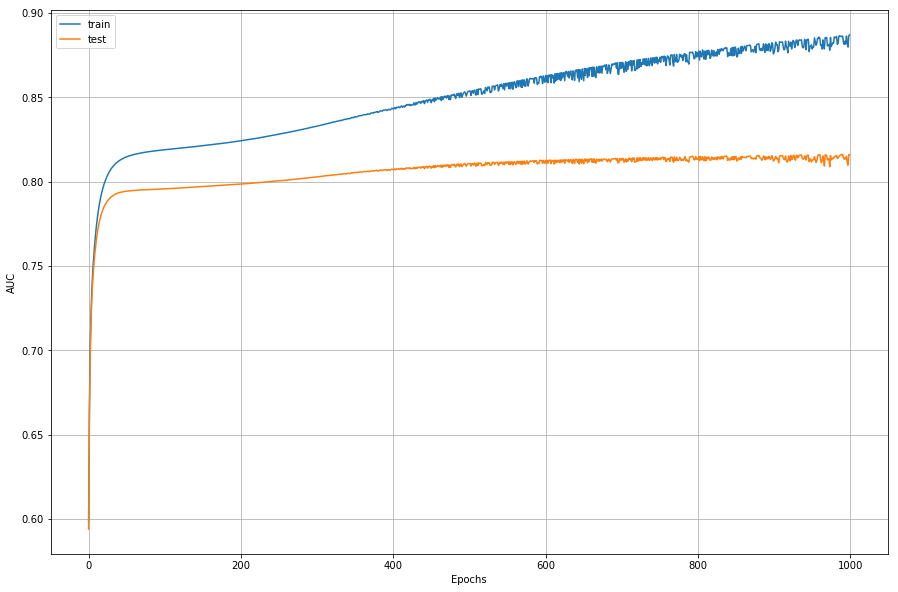

In [295]:
fig = plt.figure(figsize=(15,10))
plt.plot(auc_train,label='train')
plt.plot(auc_test,label='test')
plt.ylabel('AUC'); plt.xlabel('Epochs')
plt.grid()
plt.legend();